# Project task 02: Restaurant recommendation

In [1]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
import itertools
import matplotlib

np.random.seed(52)

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.

## 1. Load data

First download `ratings.npy` from Piazza ([download link](https://syncandshare.lrz.de/dl/fiKMoxRNusLoFpFHkXXEgvdZ/ratings.npy)).

In [2]:
ratings = np.load("ratings.npy")

In [3]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=uint32)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset.  
We **strongly recommend** to load the data as a sparse matrix to avoid out-of-memory issues.

In [4]:
# Store the matrix into the variable M
### YOUR CODE HERE ###
N = ratings[:,0].max() + 1
D = ratings[:,1].max() + 1
M = sp.csr_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), shape=(N, D), dtype=np.float64)

In [5]:
M

<337867x5899 sparse matrix of type '<class 'numpy.float64'>'
	with 929606 stored elements in Compressed Sparse Row format>

## 2. Preprocess the data

In the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings. 

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.   
**Hint**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. Store the indices of which we have data available in a separate variable.

In [6]:

def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    ### YOUR CODE HERE ###
    matrix_new = matrix.copy() # be careful of matrix copy, pass by ref by default without copy()
    while(True):
        # extract rows and columns with enough nonzero elements
        matrix_new = matrix[matrix.getnnz(1)>min_entries][:,matrix.getnnz(0)>min_entries]
        if(matrix_new.shape == matrix.shape):
            # nothing changed, already converged
            break
        else:
            # update the matrix and keep going again
            matrix = matrix_new.copy()
    print("Shape after: {}".format(matrix.shape))
    
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [7]:

def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    ### YOUR CODE HERE ###
    # Note: 
    # 1. sp.csr_matrix.mean() returns means including zero elements,
    #    so use sum() divided by getnnz() is the correct way
    # 2. np.asarray and reshape(-1) just helps to reh
    user_means = np.asarray(matrix.sum(axis=1)).reshape(-1) / matrix.getnnz(1)
    
    # Note:
    # this trick is found at this stackoverflow page
    # https://stackoverflow.com/questions/39685168/
    user_means_to_diag = sp.diags(user_means, 0)
    matrix_nnz_map = matrix.copy()
    matrix_nnz_map.data = np.ones_like(matrix_nnz_map.data)
    user_means_matrix = user_means_to_diag * matrix_nnz_map
    matrix = matrix - user_means_matrix
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means



def shift_user_mean_vec_ver(val, idx, mean):
    """
    Subtract the mean rating per user from value vector specified by index vector
    
    Parameters
    ----------
    val        : np.array, shape [n_vec, ]
                 The values of an input vector extracted from a sparse matrix with shape [N, D].
                 
    idx        : tuple, shape [2, n_vec]
                 The indices of an input vector extracted from a sparse matrix with shape [N, D].
                 
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings 
                 from the mean-shifted ones.

    Returns
    -------
    val_shifted : np.array, shape [n_vec, ]
                  The values of the input vector shifted with mean.
    """ 
    
    val_shifted = val.copy() # be careful of vector copy, pass by ref by default without copy()
    for i in range(val.shape[0]):
        val_shifted[i] -= mean[idx[i][0]]
    return val_shifted

In [8]:

def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    ### YOUR CODE HERE ###
    # get the rows and cols of nonzero entries
    rows, cols = matrix.nonzero()
    # to avoid collision between validation and test set, we pick them out together
    # then assign first n_validation entries as validation, the rest as test
    rand_spm_idx = np.random.choice(len(rows), (n_validation + n_test), replace=False)
    val_idx = tuple(zip(rows[rand_spm_idx[:n_validation]], cols[rand_spm_idx[:n_validation]]))            
    test_idx = tuple(zip(rows[rand_spm_idx[n_validation:]], cols[rand_spm_idx[n_validation:]]))
    
    # assign the values to validation/test set and put zero in matrix
    # TODO: try to find a way to avoid for-loops
    matrix_split = matrix.copy() # be careful of matrix copy, pass by ref by default without copy()
    val_values = np.zeros(n_validation)
    for i in range(n_validation):
        val_values[i] = matrix_split[val_idx[i]]
        matrix_split[val_idx[i]] = 0
    test_values = np.zeros(n_test)
    for i in range(n_test):
        test_values[i] = matrix_split[test_idx[i]]
        matrix_split[test_idx[i]] = 0
        
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values

In [9]:
M = cold_start_preprocessing(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [10]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [11]:

# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices = np.transpose(np.asarray(M.nonzero())) ### YOUR CODE HERE ###

# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = shift_user_mean_vec_ver(val_values, val_idx, user_means) ### YOUR CODE HERE ###
test_values_shifted = shift_user_mean_vec_ver(test_values, test_idx, user_means) ### YOUR CODE HERE ##



## 3. Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture.

In [12]:

def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 'random' means we initialize
             the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """

    
    if init == 'svd':

        u, s, vt=sp.linalg.svds(matrix,k)
        Q=np.matmul(u,np.diag(s))
        P=vt

    ### YOUR CODE HERE ###
    elif init == 'random':
        Q=np.random.rand(matrix.shape[0], k)
        P=np.random.rand(k,matrix.shape[1])
        
    ### YOUR CODE HERE ###
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P


In [13]:
def OLS_regression_get_Q_coeff(M, P, non_zero_idx, reg_lambda):

    """
       Optimizes the factorisation for Q given M and P

       Parameters
       ----------
       M                 : sp.spmatrix, shape [N, D]
                           The input matrix to be factorized.
                           
       P                 : np.array, shape [k, D]
                           Old value for P

       non_zero_idx      : np.array, shape [nnz, 2]
                           The indices of the non-zero entries of the un-shifted matrix to be factorized.

       reg_lambda        : float
                           The regularization strength.

       Returns
       -------

       Q_new             : np.array, shape [N, k]
                          optimal value of Q for the next iteration
    """


    R=[set() for x in range(M.shape[0])] # set of items that were rated by the user

    nz_R=set()  # set of indexes of R for items rated by non-zero number of users

    for nz in non_zero_idx:
        R[nz[0]].add(nz[1])

    Q_new = np.zeros((M.shape[0],P.shape[0]), dtype=np.float64)

    P_tr=np.transpose(P)
    R_list=list(R)
    for x, val in enumerate(R_list):
        R_x_list=list(val)
        features = P_tr[R_x_list]
        M_row=M[x, :].todense().A1

        targets = M_row[R_x_list]

        ridge = Ridge(alpha=reg_lambda)
        ret = ridge.fit(features,targets)
        Q_new[x]=ridge.coef_

    return Q_new



def OLS_regression_get_P_coeff(M, Q, non_zero_idx, reg_lambda):

    """
       Optimizes the factorisation for P given M and Q

       Parameters
       ----------
       M                 : sp.spmatrix, shape [N, D]
                           The input matrix to be factorized.

       non_zero_idx      : np.array, shape [nnz, 2]
                           The indices of the non-zero entries of the un-shifted matrix to be factorized.
                           nnz refers to the number of non-zero entries. Note that this may be different
                           from the number of non-zero entries in the input matrix M, e.g. in the case
                           that all ratings by a user have the same value.

       Q                 : np.array, shape [N, k]
                           Old value for Q
                           
       reg_lambda        : float
                           The regularization strength.


       Returns
       -------

       P_new             : np.array, shape [k, D]
                          optimal value of P for the next iteration
    """

    #Create a list of d sets, memory cons can be optimized further
    R=[set() for i in range(M.shape[1])] # set of users that rated the item
    for nz in non_zero_idx:
        R[nz[1]].add(nz[0])
  
    P_new = np.zeros((Q.shape[1], M.shape[1]),dtype=np.float64)
    P_tr=np.zeros((M.shape[1],Q.shape[1]),dtype=np.float64)

    R_list=list(R)
    for i, val in enumerate(R_list):

        R_i_list = list(val)
        features=Q[R_i_list]

        targets=(M[:,i]).todense().A1[R_i_list]
        ridge = Ridge(alpha=reg_lambda)
        ret = ridge.fit(np.asarray(features), np.asarray(targets))

        P_tr[i]=ridge.coef_

    P_new=np.transpose(P_tr)

    return P_new


def calculate_training_loss(M,M_approx, mask):
    """
       Calculates the Training Loss

       Parameters
       ----------
       M                 : sp.spmatrix, shape [N, D]
                           The input matrix to be factorized.

       M_approx          : sp.spmatrix, shape [N, D]
                           The approximated data matrix

       mask              : tuple, shape [2, n_training]
                           The indices of the non-zero entries of the Sparse Matrix M.


       Returns
       -------

       loss             : float
                          The total Training Loss(Mean Squared Error Loss)
    """

    M_diff_filt_nnz=np.multiply(M-M_approx, mask)
    loss=np.multiply(M_diff_filt_nnz,M_diff_filt_nnz).sum()
    return loss


def calculate_validation_loss(M_approx, val_idx, val_values):
    """
       Calculates the Validation Loss

       Parameters
       ----------

       M_approx          : sp.spmatrix, shape [N, D]
                           The approximated data matrix

       val_idx           : tuple, shape [2, n_validation]
                           Tuple of the validation set indices.
                           n_validation refers to the size of the validation set.
                      
       val_values        : np.array, shape [n_validation, ]
                           The values in the validation set. 


       Returns
       -------

       loss             : float
                          The total Validation Loss(Mean Squared Error Loss)
    """
    loss = np.float64()

    for ind, val in enumerate(val_values):
        x = val_idx[ind][0]
        i = val_idx[ind][1]
        loss += (val - M_approx[x,i]) ** 2

    return loss

In [14]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P observed during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
    ### YOUR CODE HERE ###
    
    train_losses=list()
    validation_losses=list()

    it=0
    converged=0
    step=0
    Q,P=initialize_Q_P(M,k,init)
    best_Q = np.copy(Q)
    best_P = np.copy(P)
    
    M_approx = np.matmul(Q, P)
    M_diff = M - M_approx
        
    mask_nnz = np.zeros((M_approx.shape[0], M_approx.shape[1]), dtype=bool)
    mask_nnz[non_zero_idx[:, 0], non_zero_idx[:, 1]] = True
    
    train_loss_min=train_loss = calculate_training_loss(M,M_approx,mask_nnz)
    valid_loss_min=valid_loss = calculate_validation_loss(M_approx, val_idx, val_values)
    
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    print("iteration "+ str(step)+", " + "training loss: "+ str(train_loss) + ", validation loss: " + str(valid_loss)) 

    temp_patience = patience
    
    start=time.time()
    
    for step in range(max_steps):
        
        P = OLS_regression_get_P_coeff(M,Q, non_zero_idx, reg_lambda)
        Q = OLS_regression_get_Q_coeff(M, P, non_zero_idx, reg_lambda)
        

        M_approx = np.matmul(Q, P)
        M_diff = M - M_approx
        
        mask_nnz = np.zeros((M_approx.shape[0], M_approx.shape[1]), dtype=bool)
        mask_nnz[non_zero_idx[:, 0], non_zero_idx[:, 1]] = True
        
        
        train_loss=calculate_training_loss(M,M_approx,mask_nnz)
        valid_loss=calculate_validation_loss(M_approx, val_idx, val_values)



        
        if ((step % eval_every)==0):
            if valid_loss > valid_loss_min : # not improving or may be increasing
                temp_patience-=1 
                best_Q=np.copy(Q)
                best_P=np.copy(P)
                if temp_patience==0:
                    break
            else: 
                temp_patience=patience
                valid_loss_min = valid_loss
                    
        if (step % log_every)==0:
            train_losses.append(train_loss)
            validation_losses.append(valid_loss)
            print("iteration "+ str(step+1)+", " + "training loss: "+ str(train_loss) + ", validation loss: " + str(valid_loss)) 
                             
      
    stop=time.time()
    if temp_patience != 0:
        best_Q=Q
        best_P=P
        converged_after=-1 
    else:
        converged_after = step + 1 - patience*eval_every
    
    print("Converged after "+ str(converged_after) + " iterations, on average " +str((stop-start)/(step+1)) + " per iteration.")

    return best_Q, best_P, validation_losses, train_losses, converged_after



#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using alternating optimization. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa. Run the alternating optimization algorithm with $k=100$ and $\lambda=1$. Plot the training and validation losses over time.

In [15]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

iteration 0, training loss: 178764368.0519325, validation loss: 125255.54703774986
iteration 1, training loss: 31197.36246405579, validation loss: 307.092604163319
iteration 2, training loss: 11125.782701813543, validation loss: 301.4105373119164
iteration 3, training loss: 8169.543864348739, validation loss: 298.71443808617454
iteration 4, training loss: 7164.151944680436, validation loss: 297.27192340522555
iteration 5, training loss: 6688.161315936695, validation loss: 296.28465342515284
iteration 6, training loss: 6413.991210016087, validation loss: 295.52634550456696
iteration 7, training loss: 6234.310170880061, validation loss: 294.9933211029217
iteration 8, training loss: 6106.614146188989, validation loss: 294.67853894679683
iteration 9, training loss: 6010.878883733507, validation loss: 294.5499987047841
iteration 10, training loss: 5936.244843575675, validation loss: 294.5582614995805
iteration 11, training loss: 5876.182011535879, validation loss: 294.65299101322097
iterati

#### Plot the validation and training losses over (training) time

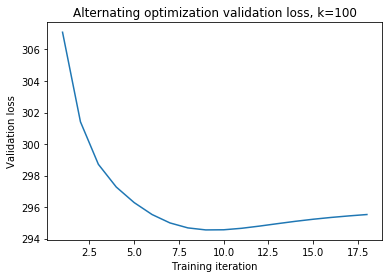

In [89]:

### YOUR PLOTTING CODE HERE ###
plt.title('Alternating optimization validation loss, k=100')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')
plt.plot(range(1,len(val_l_a)),val_l_a[1:])
plt.show()

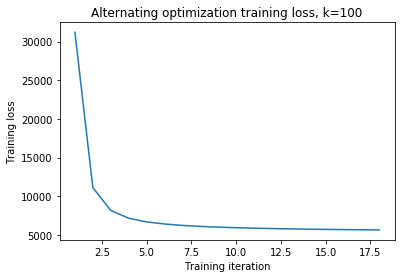

In [90]:
plt.title('Alternating optimization training loss, k=100')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.plot(range(1,len(tr_l_a)),tr_l_a[1:])
plt.show()

b) (**Optional**): Try some different latent dimensions $k$ in the range [5, 100]. What do you observe (convergence time, final training/validation losses)?

In [18]:
Q_a_2, P_a_2, val_l_a_2, tr_l_a_2, conv_a_2 = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=20, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=0.1, init='random',
                                                                           max_steps=100, patience=10)

iteration 0, training loss: 7754498.148707265, validation loss: 5585.485840748475
iteration 1, training loss: 117564.06865888457, validation loss: 345.654624931097
iteration 2, training loss: 91386.36743466838, validation loss: 330.38934251579593
iteration 3, training loss: 78334.2971446737, validation loss: 329.1312704053438
iteration 4, training loss: 70320.970683888, validation loss: 321.78726014603643
iteration 5, training loss: 64891.964021806736, validation loss: 316.19468705203155
iteration 6, training loss: 60898.79968187357, validation loss: 311.3277520690476
iteration 7, training loss: 57886.57254661791, validation loss: 309.70620184557254
iteration 8, training loss: 55429.756540419876, validation loss: 308.166714148954
iteration 9, training loss: 53378.45785178607, validation loss: 306.71834806939313
iteration 10, training loss: 51649.1993589902, validation loss: 305.1769813493359
iteration 11, training loss: 50168.134325285384, validation loss: 305.48001515429894
iteration 

#### Plot the validation and training losses over (training) time

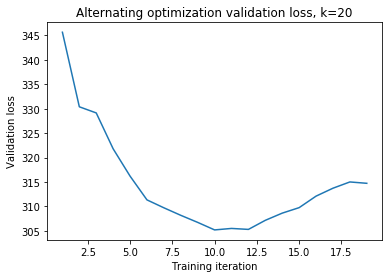

In [91]:
### YOUR PLOTTING CODE HERE ###
plt.title('Alternating optimization validation loss, k=20')
plt.xlabel('Training iteration')
plt.ylabel('Validation loss')
plt.plot(range(1,len(val_l_a_2)),val_l_a_2[1:])
plt.show()

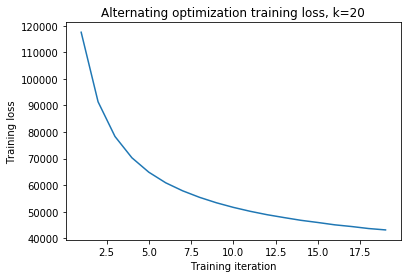

In [92]:
plt.title('Alternating optimization training loss, k=20')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.plot(range(1,len(tr_l_a_2)),tr_l_a_2[1:])
plt.show()

## 4. Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent. You can use the following equations for your implementation.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known (in this case our known play counts). Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. To help you solve the task we provide the following:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

**Hint**: You have to carefully consider how to combine the given partial gradients depending
on which variants of gradient descent you are using.  
**Hint 2**: It may be useful to scale the updates to $P$ and $Q$ by $\frac{1}{batch\_size}$ (in the case of full-sweep updates, this would be $\frac{1}{n\_users}$ for $Q$ and $\frac{1}{n\_restaurants}$ for $P$).


For each of the gradients descent variants you try report and compare the following:
* How many iterations do you need for convergence.
* Plot the loss (y axis) for each iteration (x axis).


In [21]:
def gradient_descent_get_Q_grad(M,M_approx,M_diff_filt,mask,Q,P,non_zero_idx, reg_lambda):

    """
           Returns gradient update for P given M and Q

           Parameters
           ----------
           M                 : sp.spmatrix, shape [N, D]
                               The input matrix to be factorized.
                               
           M_approx          : sp.spmatrix, shape [N, D]
                               The Approximated Matrix (M = QP).
                               
           M_diff_filt       : np.array, shape [Mini-batch Size, D]
                               The Approximated Matrix (M = QP) for the Mini Batch
                               
           mask              : tuple, shape [2, n_training]
                               The indices of the non-zero entries of the Sparse Matrix M.
                               

           non_zero_idx      : np.array, shape [nnz, 2]
                               The indices of the non-zero entries of the un-shifted matrix to be factorized.
                               
           P                 : np.array, shape [k, D]
                               Value for P matrix

           Q                 : np.array, shape [N, k]
                               Value for Q matrix
                               
           reg_lambda        : float
                               The regularization strength.


           Returns
           -------

           P_grad            : float
                               The gradient of matrix P
        """

    # create a list of d sets, memory cons can be optimized further

    lambda_d = np.float64()
    lambda_d += 2 * reg_lambda
    P_tr = np.transpose(P)

    Q_grad = -2 * np.matmul(M_diff_filt, P_tr)
    items_vect=np.ones(M.shape[1])

    scale_coefs=np.matmul(mask,items_vect) * lambda_d # number of items for each user * lambda_d

    scale_diag=np.diag(scale_coefs)

    Q_grad_add=np.matmul(scale_diag,Q)

    Q_grad+=Q_grad_add

    return Q_grad

def gradient_descent_get_P_grad(M,M_approx,M_diff_filt,mask,Q,P,non_zero_idx, reg_lambda):
    """
           Returns gradient update for P given M and Q

           Parameters
           ----------
           M                 : sp.spmatrix, shape [N, D]
                               The input matrix to be factorized.
                               
           M_approx          : sp.spmatrix, shape [N, D]
                               The Approximated Matrix (M = QP).
                               
           M_diff_filt       : np.array, shape [Mini-batch Size, D]
                               The Approximated Matrix (M = QP) for the Mini Batch
                               
           mask              : tuple, shape [2, n_training]
                               The indices of the non-zero entries of the Sparse Matrix M.
                               

           non_zero_idx      : np.array, shape [nnz, 2]
                               The indices of the non-zero entries of the un-shifted matrix to be factorized.
                               
           P                 : np.array, shape [k, D]
                               Value for P matrix

           Q                 : np.array, shape [N, k]
                               Value for Q matrix
                               
           reg_lambda        : float
                               The regularization strength.


           Returns
           -------

           Q_grad            : float
                               The gradient of matrix Q
        """

    # create a list of d sets, memory cons can be optimized further

    lambda_d=np.float64()

    lambda_d += 2 * reg_lambda

    Q_tr = np.transpose(Q)

    P_grad = -2 * np.matmul(Q_tr,M_diff_filt)

    users_vect=np.ones(M.shape[0])

    scale_coefs=np.matmul(users_vect,mask) * lambda_d # number of items for each user * lambda_d

    scale_diag=np.diag(scale_coefs)

    P_grad_add=np.matmul(P,scale_diag)

    P_grad += P_grad_add

    return P_grad



def gradient_descent_get_P_grad_minibatch_iter(M, Q, P, non_zero_idx, reg_lambda):
    #M_diff_d=-2*M_diff_filt
    a = 0
    R = dict()
    for x, i in non_zero_idx:
        R.setdefault(i, [])
        R[i].append(x)

    lambda_d = 2 * reg_lambda

    P_tr = np.transpose(P)
    P_grad = np.zeros((Q.shape[1], M.shape[1]), dtype=np.float64)  # size -
    P_grad_tr = np.zeros((M.shape[1], Q.shape[1]), dtype=np.float64)  # size D x k

    for i, val in R.items():
        P_grad_cur = len(val) * lambda_d * P_tr[i]
        for x in val:
            P_grad_cur += -2*(M[x, i]-np.matmul(Q[x],P_tr[i])) * Q[x]
        P_grad_tr[i] = P_grad_cur
        # P_grad_tr[i] += M_diff_d[x, i] * Q[x] + lambda_d * P_tr[i]
    P_grad = np.transpose(P_grad_tr)

    return P_grad

def gradient_descent_get_Q_grad_minibatch_iter(M,Q,P,non_zero_idx, reg_lambda):
    #M_diff_d = -2 * M_diff_filt
    R = dict()
    for x, i in non_zero_idx:
        R.setdefault(x, [])
        R[x].append(i)

    lambda_d = 2 * reg_lambda

    P_tr = np.transpose(P)
    Q_grad = np.zeros((M.shape[0], P.shape[0]), dtype=np.float64)  # size -

    Q_grad_cur = np.zeros(P.shape[0])

    for x, val in R.items():
        Q_grad_cur = len(val)*lambda_d * Q[x]

        for i in val:
            Q_grad_cur += -2*(M[x, i]-np.matmul(Q[x],P_tr[i])) * P_tr[i]
        Q_grad[x] = Q_grad_cur

    return Q_grad





In [22]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
       
    Q,P=initialize_Q_P(M,k,init)

    # calculate P
    best_Q=np.copy(Q)
    best_P=np.copy(P)


    train_losses=list()
    validation_losses=list()


    M_approx = np.matmul(Q, P)

    mask_nnz = np.zeros((M_approx.shape[0], M_approx.shape[1]), dtype=bool)
    mask_nnz[non_zero_idx[:, 0], non_zero_idx[:, 1]] = True

    train_loss=train_loss_old = calculate_training_loss(M, M_approx, mask_nnz )
    valid_loss=valid_loss_old = calculate_validation_loss(M_approx, val_idx, val_values)

    it=0
    converged=0

    patience_cur = patience

    n_train = non_zero_idx.shape[0]

    mini_batch_size = batch_size
    assert (mini_batch_size <= n_train)

    if (batch_size == -1):
        mini_batch_size = n_train

    assert (mini_batch_size > 0)


    permuted_nnz_indices=nonzero_indices.copy()
    np.random.shuffle(permuted_nnz_indices)

    permut_start=0
    
    step=0
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    print("iteration "+ str(step)+", " + "training loss: "+ str(train_loss) + ", validation loss: " + str(valid_loss))
 
    start=time.time()
    
    for step in range(max_steps):

        if(permut_start+mini_batch_size <= n_train):
            mini_batch_indices = permuted_nnz_indices[permut_start: permut_start + mini_batch_size]
            permut_start+=mini_batch_size
        else:
            #TODO: Test this
            mini_batch_indices0 = permuted_nnz_indices[permut_start: n_train-permut_start]
            mini_batch_indices1 = permuted_nnz_indices[0: mini_batch_size-n_train+permut_start]
            mini_batch_indices = np.concatenate((mini_batch_indices0,mini_batch_indices1))

        if(mini_batch_size<1000):

            Q_grad = gradient_descent_get_Q_grad_minibatch_iter(M, Q, P, mini_batch_indices,
                                                 reg_lambda)
            P_grad = gradient_descent_get_P_grad_minibatch_iter(M, Q, P, mini_batch_indices,
                                         reg_lambda)

            #test_grad_iter(M,mask_minibatch,Q,P,mini_batch_indices,reg_lambda)

        else:

            M_approx = np.matmul(Q, P)

            # cols = list(non_zero_idx[:1])
            mask_minibatch = np.zeros((M_approx.shape[0], M_approx.shape[1]), dtype=bool)
            mask_minibatch[mini_batch_indices[:, 0], mini_batch_indices[:, 1]] = True

            #cache the value in memory for better speed, TODO: make it sparse?
            M_diff_filt=np.multiply(M - M_approx, mask_minibatch)


            Q_grad = gradient_descent_get_Q_grad(M,M_approx,M_diff_filt,mask_minibatch,Q,P,mini_batch_indices,reg_lambda)
            
            P_grad= gradient_descent_get_P_grad(M,M_approx,M_diff_filt,mask_minibatch,Q,P,mini_batch_indices,reg_lambda)
            
            #test_grad(M,M_approx,M_diff_filt,mask_minibatch,Q,P,mini_batch_indices,reg_lambda)


        factor=len(non_zero_idx)/np.float64(mini_batch_size)
        #factor=1/np.float64(mini_batch_size)
        
        P = P - learning_rate * factor * P_grad
        Q = Q - learning_rate * factor * Q_grad

        if ((step+1) % eval_every==0):
            M_approx = np.matmul(Q, P)

            train_loss = calculate_training_loss(M,M_approx, mask_nnz)
            valid_loss = calculate_validation_loss(M_approx, val_idx, val_values)
            
            train_losses.append(train_loss)
            validation_losses.append(valid_loss)
            
            #testLosses(M,M_approx, mask_nnz,non_zero_idx)
    
            if (valid_loss_old > valid_loss):
                converged = 0
                patience_cur = patience

                valid_loss_old = valid_loss
                best_Q = np.copy(Q)
                best_P = np.copy(P)
            else:
                patience_cur -= 1
                if (patience_cur == 0):
                    converged = 1
                    it = step
                    break
        if (step>0) and ((step % log_every) == 0):
            print("iteration "+ str(step)+", " + "training loss: "+ str(train_loss) + ", validation loss: " + str(valid_loss)) 

    if(converged==0):
        converged_after=-1
    else:
        converged_after=it - patience
    stop=time.time()
    
    print("Converged after "+ str(converged_after+1) + " iterations, on average " +str((stop-start)/step) + " per iteration.")
            
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with alternating optimization.

a) Learn the optimal $P$ and $Q$ using standard gradient descent. That is, during each iteration you have to use all of the training examples and update $Q$ and $P$ for all users and songs at once. Try the algorithm with $k=30$, $\lambda=1$, and learning rate of 0.1. Initialize $Q$ and $P$ with SVD.  

In [23]:
eval_every = 20
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1e-3, learning_rate=1e-3,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

iteration 0, training loss: 301198.33929534483, validation loss: 293.7182511581806
iteration 20, training loss: 252572.4745373722, validation loss: 292.72477822063803
iteration 40, training loss: 179106.62909831086, validation loss: 289.6332165283658
iteration 60, training loss: 142247.44259593336, validation loss: 289.3004241653402
iteration 80, training loss: 112347.98705552884, validation loss: 289.81397407494273
iteration 100, training loss: 88999.32609456763, validation loss: 290.8082423282595
iteration 120, training loss: 71535.56762667868, validation loss: 292.15961523701475
iteration 140, training loss: 58719.94090467728, validation loss: 293.5958055047857
iteration 160, training loss: 49306.00346375035, validation loss: 294.7463112304531
iteration 180, training loss: 42299.37114962933, validation loss: 295.40675114551186
iteration 200, training loss: 36983.70246703712, validation loss: 295.5893501117671
iteration 220, training loss: 32865.24475047793, validation loss: 295.4182

#### Plot the validation and training losses over (training) time

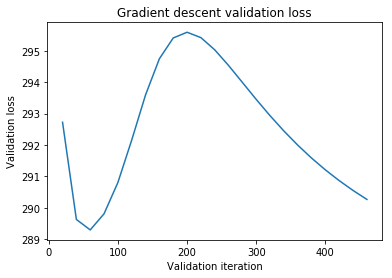

In [93]:
eval_every = 20
### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent validation loss')
plt.xlabel('Validation iteration')
plt.ylabel('Validation loss')
xlabel = [x * eval_every for x in range(1,len(val_l_g_sweep))]
plt.plot(xlabel,val_l_g_sweep[1:])
plt.show()

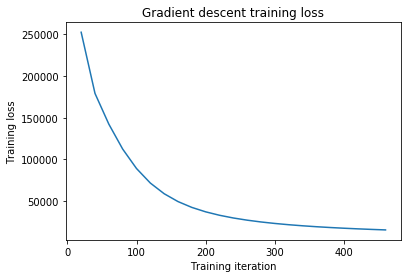

In [94]:
### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent training loss')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
xlabel = [x * eval_every for x in range(1,len(tr_l_g_sweep))]
plt.plot(xlabel,tr_l_g_sweep[1:])
plt.show()

b) Learn the optimal $P$ and $Q$ using the original stochastic gradient descent (mini-batches of size 1). That is, during each iteration you sample a single random training example $r_{xi}$ and update only the respective affected parameters $\mathbf{p_x}$ and $\mathbf{q}_i$. Set the learning rate to 0.01 and keep the other parameters as in a).

In [26]:
eval_every=50
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-3, learning_rate=1e-8,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

iteration 0, training loss: 301198.3392953448, validation loss: 293.7182511581805
iteration 500, training loss: 301105.09179512213, validation loss: 293.65491076733457
iteration 1000, training loss: 301018.7210675117, validation loss: 293.6213616065879
iteration 1500, training loss: 300922.7695515784, validation loss: 293.6732442290683
iteration 2000, training loss: 300827.3532545681, validation loss: 293.43345681646645
iteration 2500, training loss: 300715.3943331198, validation loss: 293.46389189250874
iteration 3000, training loss: 300642.8931027484, validation loss: 293.35816167004316
iteration 3500, training loss: 300517.062249607, validation loss: 293.80187813267156
iteration 4000, training loss: 300431.6423959902, validation loss: 293.6766239301518
Converged after 4130 iterations, on average 0.033116474700968186 per iteration.


#### Plot the validation and training losses over (training) time

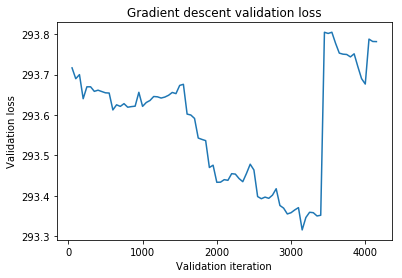

In [95]:
eval_every=50
### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent validation loss')
plt.xlabel('Validation iteration')
plt.ylabel('Validation loss')
xlabel = [x * eval_every for x in range(1,len(val_l_g_st))]
plt.plot(xlabel,val_l_g_st[1:])
plt.show()

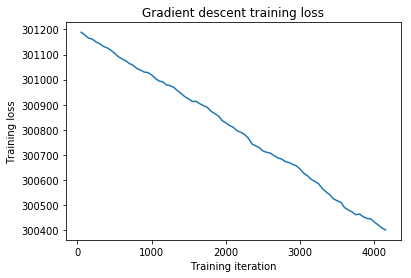

In [96]:
### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent training loss')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
xlabel = [x * eval_every for x in range(1,len(tr_l_g_st))]
plt.plot(xlabel,tr_l_g_st[1:])
plt.show()

c) (**Optional**) Learn the optimal $P$ and $Q$ similarly to b) this time using larger mini-batches of size $S$, e.g. 32.

In [60]:
eval_every=50
Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-3, learning_rate=1e-7,
                                                                                   init='svd', batch_size=32,
                                                                                   max_steps=10000, log_every=100, 
                                                                                   eval_every=50)

iteration 0, training loss: 301198.33929534483, validation loss: 293.71825115818046
iteration 100, training loss: 300976.30228992313, validation loss: 293.76955365292014
iteration 200, training loss: 300762.421272659, validation loss: 293.68959068753026
iteration 300, training loss: 300550.58096098737, validation loss: 293.4926893874871
iteration 400, training loss: 300342.22058859665, validation loss: 293.51374691067247
iteration 500, training loss: 300140.5519207642, validation loss: 293.56488596001674
iteration 600, training loss: 299949.3485957993, validation loss: 293.5977951549273
iteration 700, training loss: 299757.4204069429, validation loss: 293.52227795035134
iteration 800, training loss: 299559.69648007426, validation loss: 293.67460207282244
iteration 900, training loss: 299380.8183537193, validation loss: 293.6172989013629
iteration 1000, training loss: 299195.4021400283, validation loss: 293.36836746560044
iteration 1100, training loss: 298985.82490536984, validation los

#### Plot the validation and training losses over (training) time

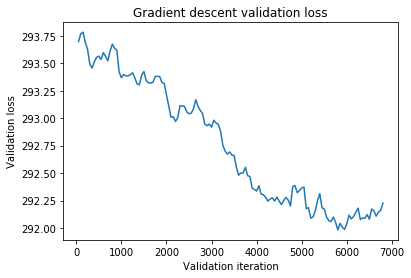

In [97]:
eval_every=50
### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent validation loss')
plt.xlabel('Validation iteration')
plt.ylabel('Validation loss')
xlabel = [x * eval_every for x in range(1,len(val_l_g_mb))]
plt.plot(xlabel,val_l_g_mb[1:])
plt.show()

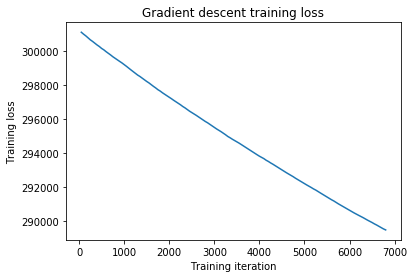

In [98]:

### YOUR PLOTTING CODE HERE ###
plt.title('Gradient descent training loss')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
xlabel = [x * eval_every for x in range(1,len(tr_l_g_mb))]
plt.plot(xlabel,tr_l_g_mb[1:])
plt.show()

### 4.5 Hyperparameter search

Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

### Tasks:

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, randomly sample three values in the interval [0, 1).
* For the learning rate, evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, uniformly sample three values in the interval [5,30].

Perform an exhaustive search among all combinations of these values;

**Hint**: This may take a while to compute. **You don't have to wait for all the models to train** -- simply use "dummy" code instead of actual model training (or let it train, e.g., for only one iteration) if you don't want to wait. Note that the signature of this dummy code has to match the function 'latent_factor_gradient_descent' so that we could simply plug in the actual function.



In [74]:
def parameter_search(M_train, val_idx, val_values):
    """
    Hyperparameter search using random search.
    
    Parameters
    ----------
    
    M_train     : sp.spmatrix, shape [N, D]
                  Input sparse matrix where the user means have not
                  been subtracted yet. 
                  
    val_idx     : tuple, shape [2, n_validation]
                  The indices used for validation, where n_validation
                  is the size of the validation set.
                  
    val_values  : np.array, shape [n_validation, ]
                  Validation set values, where n_validation is the
                  size of the validation set.

    Returns
    -------
    best_conf   : tuple, (batch_size, lambda, learning_rate, latent_dimension)
                  The best-performing hyperparameters.
                  

    """
    
    ### YOUR CODE HERE ###
    batch_size = np.array([1, 32, 512, -1])
    reg_strength = np.array([1e-3,1e-2,1e-1])
    #reg_strength = np.array([0.1*np.random.ranf(),0.1*np.random.ranf(),0.1*np.random.ranf()])
    learning_rate = np.array([1e-4,1e-3,1e-5])
    latent_dim = np.array([10,20,30])

    min_loss = 9999999
    for batch_val in batch_size:
        for reg in reg_strength:
            for lr in learning_rate:
                for dim in latent_dim:
                    print("bs = ", batch_val, " reg = ", reg, " lr = ", lr, " dim = ", dim)
                    Q_tmp, P_tmp, val_l_tmp, tr_l_tmp, conv_tmp = latent_factor_gradient_descent(
                                                    M_shifted, nonzero_indices,dim,val_idx,
                                                    val_values=val_values_shifted, 
                                                    reg_lambda=reg, learning_rate=lr,
                                                    init='svd', batch_size=batch_val,
                                                    max_steps=20, log_every=20,eval_every=20)
                    if(min(val_l_tmp)< min_loss):
                        min_loss = min(val_l_tmp)
                        best_bs = batch_val
                        best_reg = reg
                        best_lr = lr
                        best_dim = dim
                    
    
    best_conf = (best_bs, best_reg, best_lr, best_dim) 
    print("Best configuration is ",best_conf)
    return best_conf
    

In [75]:
best_configuration = parameter_search(M_train, val_idx, val_values)

bs =  1  reg =  0.0005335082595873919  lr =  1e-08  dim =  10
iteration 0, training loss: 321663.7105245502, validation loss: 291.17295767189
Converged after 0 iterations, on average 0.06796408954419587 per iteration.
bs =  1  reg =  0.0005335082595873919  lr =  1e-08  dim =  20
iteration 0, training loss: 310941.66342753987, validation loss: 293.22029316055784
Converged after 0 iterations, on average 0.0712680691166928 per iteration.
bs =  1  reg =  0.0005335082595873919  lr =  1e-08  dim =  30
iteration 0, training loss: 301198.3392953448, validation loss: 293.7182511581806
Converged after 0 iterations, on average 0.07490892159311395 per iteration.
bs =  1  reg =  0.0005335082595873919  lr =  0.001  dim =  10
iteration 0, training loss: 321663.7105245501, validation loss: 291.17295767189
Converged after 0 iterations, on average 0.06723549491480778 per iteration.
bs =  1  reg =  0.0005335082595873919  lr =  0.001  dim =  20
iteration 0, training loss: 310941.66342753987, validation lo

Converged after 0 iterations, on average 0.08894860117059004 per iteration.
bs =  32  reg =  0.09428909572901459  lr =  1e-08  dim =  30
iteration 0, training loss: 301198.3392953448, validation loss: 293.7182511581805
Converged after 0 iterations, on average 0.08266059975875051 per iteration.
bs =  32  reg =  0.09428909572901459  lr =  0.001  dim =  10
iteration 0, training loss: 321663.7105245502, validation loss: 291.17295767189
Converged after 0 iterations, on average 0.08217736294395045 per iteration.
bs =  32  reg =  0.09428909572901459  lr =  0.001  dim =  20
iteration 0, training loss: 310941.6634275398, validation loss: 293.22029316055784
Converged after 0 iterations, on average 0.07650903651588842 per iteration.
bs =  32  reg =  0.09428909572901459  lr =  0.001  dim =  30
iteration 0, training loss: 301198.3392953448, validation loss: 293.7182511581805
Converged after 0 iterations, on average 0.0800307173477976 per iteration.
bs =  32  reg =  0.09428909572901459  lr =  1e-06 

c:\programdata\anaconda3-64\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: overflow encountered in multiply
c:\programdata\anaconda3-64\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in multiply
c:\programdata\anaconda3-64\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: overflow encountered in multiply
c:\programdata\anaconda3-64\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: overflow encountered in double_scalars


Converged after 0 iterations, on average 0.14594794574536776 per iteration.
bs =  512  reg =  0.0005335082595873919  lr =  0.001  dim =  20
iteration 0, training loss: 310941.6634275398, validation loss: 293.22029316055784


c:\programdata\anaconda3-64\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: overflow encountered in multiply


Converged after 0 iterations, on average 0.14363657800774826 per iteration.
bs =  512  reg =  0.0005335082595873919  lr =  0.001  dim =  30
iteration 0, training loss: 301198.3392953448, validation loss: 293.7182511581805
Converged after 0 iterations, on average 0.15109843956796745 per iteration.
bs =  512  reg =  0.0005335082595873919  lr =  1e-06  dim =  10
iteration 0, training loss: 321663.7105245501, validation loss: 291.17295767189
Converged after 0 iterations, on average 0.14539093720285515 per iteration.
bs =  512  reg =  0.0005335082595873919  lr =  1e-06  dim =  20
iteration 0, training loss: 310941.6634275398, validation loss: 293.22029316055784
Converged after 0 iterations, on average 0.15383428021481163 per iteration.
bs =  512  reg =  0.0005335082595873919  lr =  1e-06  dim =  30
iteration 0, training loss: 301198.3392953447, validation loss: 293.7182511581805
Converged after 0 iterations, on average 0.1448218069578472 per iteration.
bs =  512  reg =  0.09428909572901459 

iteration 0, training loss: 321663.7105245502, validation loss: 291.17295767189
Converged after 0 iterations, on average 2.9817547672673275 per iteration.
bs =  -1  reg =  0.09428909572901459  lr =  1e-06  dim =  20
iteration 0, training loss: 310941.66342753987, validation loss: 293.22029316055784
Converged after 0 iterations, on average 3.0488408741198088 per iteration.
bs =  -1  reg =  0.09428909572901459  lr =  1e-06  dim =  30
iteration 0, training loss: 301198.3392953449, validation loss: 293.71825115818064
Converged after 0 iterations, on average 3.172553401244314 per iteration.
bs =  -1  reg =  0.08288459283018823  lr =  1e-08  dim =  10
iteration 0, training loss: 321663.7105245502, validation loss: 291.17295767189
Converged after 0 iterations, on average 3.0368814593867253 per iteration.
bs =  -1  reg =  0.08288459283018823  lr =  1e-08  dim =  20
iteration 0, training loss: 310941.6634275399, validation loss: 293.2202931605578
Converged after 0 iterations, on average 3.05220

KeyboardInterrupt: 

#### Output the best hyperparameter optimization

In [34]:
### YOUR CODE HERE ###
print("Best batch size = ",best_configuration[0])
print("Best lambda = ",best_configuration[1])
print("Best learning rate = ",best_configuration[2])
print("Best latent dimension = ",best_configuration[3])

Q_best, P_best, val_l_best, tr_l_best, conv_best = latent_factor_gradient_descent(
                                                    M_shifted, nonzero_indices,best_configuration[3],val_idx,
                                                    val_values=val_values_shifted, 
                                                    reg_lambda=best_configuration[1],
                                                    learning_rate=best_configuration[2],
                                                    init='svd', batch_size=best_configuration[0],
                                                    max_steps=1000, log_every=20,eval_every=20)

Best batch size =  -1
Best lambda =  0.001
Best learning rate =  0.001
Best latent dimension =  10
iteration 0, training loss: 321663.7105245502, validation loss: 291.17295767189
iteration 20, training loss: 314115.683135582, validation loss: 281.82394214189816
iteration 40, training loss: 251890.63049701892, validation loss: 275.0635451080529
iteration 60, training loss: 227150.000192135, validation loss: 272.19620645956036
iteration 80, training loss: 204855.6496641357, validation loss: 270.1281011168847
iteration 100, training loss: 185994.64432338715, validation loss: 268.6369101345874
iteration 120, training loss: 170777.0058029325, validation loss: 267.4914137641847
iteration 140, training loss: 158777.41820952878, validation loss: 266.9055816657822
iteration 160, training loss: 149352.6991406205, validation loss: 267.1029862636484
iteration 180, training loss: 141890.03106057516, validation loss: 268.05735327985815
iteration 200, training loss: 135895.70690331774, validation los

## 5. Comparison of gradient descent and alternating optimization

After training the latent factor model with both alternating optimization and gradient descent, we now compare their results on the training, validation, and test set.

### Tasks

* Compare the root mean square errors (RMSE) for the training, validation, and test sets different settings of $k$ for both alternating optimization and gradient descent. What do you observe?
* Compare the test RMSE for the alternating optimization model and the gradient descent model. Which performs better?
* Plot the predicted ratings

**Hint**: The output values and plots below are the ones we got when testing this sheet. Yours may be different, but if your validation or test RMSE values are larger than 1.5 or 2, it is likely that you have a bug in your implementation.

In [54]:
### YOUR CODE HERE ###
def compute_rmse (golden_sp, result_np, non_zero_idx):
    """
    Compute the RMSE of a result in NumPy format with the golden in CSR sparse matrix format
    
    Parameters
    ----------
    golden_sp         : sp.spmatrix, shape [N, D]
                        The golden sparse matrix.
                        
    result_np         : np.array, shape [N, D]
                        The result dense matrix.
                        
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the golden matrix before mean shift.
    """
    assert(golden_sp.shape == result_np.shape) # sanity assertion of input matrices
    mask = np.zeros(result_np.shape)
    mask[non_zero_idx[:,0],non_zero_idx[:,1]] = 1
    result_masked_sp = sp.csr_matrix(np.multiply(result_np, mask))
    golden_masked_sp = golden_sp.multiply(sp.csr_matrix(mask))
    error_sp = result_masked_sp - golden_masked_sp 
    assert(error_sp.nnz <= non_zero_idx.shape[0]) # sanity assertion of number of nonzero elements
    # note: error_sp.nnz may be smaller than non_zero_idx.shape[0]
    #       use non_zero_idx.shape[0] for mean denominator
    error_rms = (error_sp.power(2).sum() / non_zero_idx.shape[0])**0.5
    return error_rms

def compute_rmse_val (result_np, val_idx):

    for i in val_idx:
        loss = np.float64()

        for ind, val in enumerate(val_values_shifted):
            x = val_idx[ind][0]
            i = val_idx[ind][1]
            loss += (val - result_np[x, i]) ** 2

        return np.sqrt(loss/len(val_idx))

def compute_rmse_test (result_np, test_idx):
    for i in test_idx:
        loss = np.float64()

        for ind, val in enumerate(test_values_shifted):
            x = test_idx[ind][0]
            i = test_idx[ind][1]
            loss += (val - result_np[x, i]) ** 2

        return np.sqrt(loss / len(test_idx))

In [76]:
 ### YOUR CODE HERE ###
 
# AltOpt k=100
M_approx_a = np.matmul(Q_a,P_a)
rmse_trn_altopt_k100 = compute_rmse(M_shifted, M_approx_a, np.transpose(np.asarray(M_train.nonzero())))
rmse_val_altopt_k100 = compute_rmse_val(M_approx_a, val_idx)
rmse_test_altopt_k100 = compute_rmse_test(M_approx_a, test_idx)
print("Training RMSE of Alternative Optimization k=100: ", rmse_trn_altopt_k100)
print("Validation RMSE of Alternative Optimization k=100: ", rmse_val_altopt_k100)
print("Test RMSE of Alternative Optimization k=100: ", rmse_test_altopt_k100)
# AltOpt k=20
M_approx_a_2 = np.matmul(Q_a_2,P_a_2)
rmse_trn_altopt_k20 = compute_rmse(M_shifted, M_approx_a_2, np.transpose(np.asarray(M_train.nonzero())))
rmse_val_altopt_k20 = compute_rmse_val(M_approx_a_2, val_idx)
rmse_test_altopt_k20 = compute_rmse_test(M_approx_a_2, test_idx)
print("Training RMSE of Alternative Optimization k=20: ", rmse_trn_altopt_k20)
print("Validation RMSE of Alternative Optimization k=20: ", rmse_val_altopt_k20)
print("Test RMSE of Alternative Optimization k=20: ", rmse_test_altopt_k20)


Training RMSE of Alternative Optimization k=100:  0.1405668309757026
Validation RMSE of Alternative Optimization k=100:  1.21574246246968
Test RMSE of Alternative Optimization k=100:  1.1530198216928524
Training RMSE of Alternative Optimization k=20:  0.386299051713161
Validation RMSE of Alternative Optimization k=20:  1.254344370587005
Test RMSE of Alternative Optimization k=20:  1.192562126260382


In [56]:

### YOUR CODE HERE ###
M_approx_g_sweep = np.matmul(Q_g_sweep,P_g_sweep)
rmse_trn_g_sweep = compute_rmse(M_shifted, M_approx_g_sweep, np.transpose(np.asarray(M_train.nonzero())))
rmse_val_g_sweep = compute_rmse_val( M_approx_g_sweep, val_idx)
rmse_test_g_sweep = compute_rmse_test( M_approx_g_sweep, test_idx)
print("Training RMSE of Gradient Descent full sweep: ", rmse_trn_g_sweep)
print("Validation RMSE of Gradient Descent full sweep: ", rmse_val_g_sweep)
print("Test RMSE of Gradient Descent full sweep: ", rmse_test_g_sweep)
# SGD best
M_approx_best = np.matmul(Q_best,P_best)
rmse_trn_best = compute_rmse(M_shifted, M_approx_best, np.transpose(np.asarray(M_train.nonzero())))
rmse_val_best = compute_rmse_val(M_approx_best, val_idx)
rmse_test_best = compute_rmse_test( M_approx_best, test_idx)
print("Training RMSE of Gradient Descent best: ", rmse_trn_best)
print("Validation RMSE of Gradient Descent best: ", rmse_val_best)
print("Test RMSE of Gradient Descent best: ", rmse_test_best)



Training RMSE of Gradient Descent full sweep:  0.7064195553925685
Validation RMSE of Gradient Descent full sweep:  1.202706165622635
Test RMSE of Gradient Descent full sweep:  1.1622835065168953
Training RMSE of Gradient Descent best:  0.7462901651419953
Validation RMSE of Gradient Descent best:  1.1552176887188454
Test RMSE of Gradient Descent best:  1.1590782510393833


#### Plots: Prediction vs. ground truth ratings

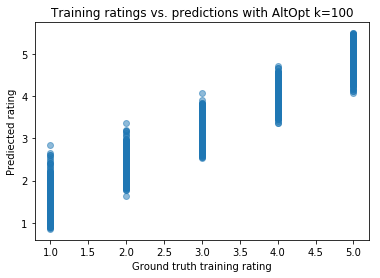

In [38]:

### YOUR PLOTTING CODE HERE ###
### YOUR PLOTTING CODE HERE ###
user_means_matrix = user_means[:,np.newaxis] # once for all plots

M_pred_a = M_approx_a + user_means_matrix
x = M.A[M_train.nonzero()]
y = M_pred_a[M_train.nonzero()]
plt.title('Training ratings vs. predictions with AltOpt k=100')
plt.xlabel('Ground truth training rating')
plt.ylabel('Prediected rating')
plt.scatter(x,y, alpha=0.5)
plt.show()



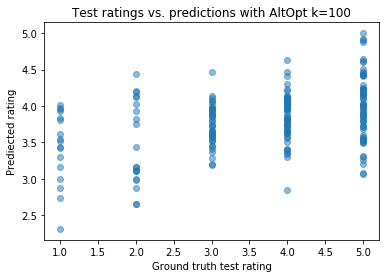

In [39]:

### YOUR PLOTTING CODE HERE ###
### YOUR PLOTTING CODE HERE ###
test_idx_a = np.asarray(test_idx)
test_idx_b = (test_idx_a[:,0],test_idx_a[:,1]) # once for all plots

x = M.A[test_idx_b]
y = M_pred_a[test_idx_b]
plt.title('Test ratings vs. predictions with AltOpt k=100')
plt.xlabel('Ground truth test rating')
plt.ylabel('Prediected rating')
plt.scatter(x,y, alpha=0.5)
plt.show()


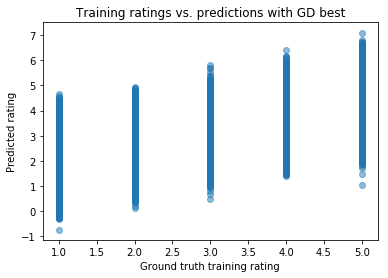

In [40]:

### YOUR PLOTTING CODE HERE ###
### YOUR PLOTTING CODE HERE ###
M_pred_best = M_approx_best + user_means_matrix
x = M.A[M_train.nonzero()]
y = M_pred_best[M_train.nonzero()]
plt.title('Training ratings vs. predictions with GD best')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')
plt.scatter(x,y, alpha=0.5)
plt.show()



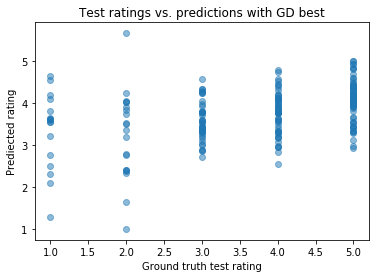

In [41]:

### YOUR PLOTTING CODE HERE ###
 ### YOUR PLOTTING CODE HERE ###
x = M.A[test_idx_b]
y = M_pred_best[test_idx_b]
plt.title('Test ratings vs. predictions with GD best')
plt.xlabel('Ground truth test rating')
plt.ylabel('Prediected rating')
plt.scatter(x,y, alpha=0.5)
plt.show()
